# Bayesian MBG estimation

## Geostatistical Modeling

In [214]:
import pymc as pm
#import aesara.tensor as at
#from aesara.graph.basic import Constant
import os
import pickle
import numpy as np
import arviz as az
import pandas as pd


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
import pytensor.tensor as at
import functions

import uuid

In [215]:
# Get the number of CPU cores to max out the machine in the traning stage
num_cores = os.cpu_count()

print(f"Number of CPU cores: {num_cores}")

Number of CPU cores: 8


### Parameters

In [251]:
#Load report
with open('temp_files/report/report.pkl', 'rb') as pickle_file:
    report = pickle.load(pickle_file)

In [252]:
report

{'Country': 'KHM',
 'DHS survey year': 2014,
 'Target Indicator': 'mpi',
 'Urban-rural threshold': 25,
 'Buffer Size (KM)': 10.0,
 'DHS clusters before urban masking': 611,
 'Grids before masking': 7793,
 'CRS': 'WGS 84',
 'Grids after masking': 7667,
 'DHS clusters after masking': 534,
 'Girds with multiple clusters': 433,
 'Covariates before filtering': 215,
 'Covariates after filtering by -+ 1y': 67,
 'Covariates after square and square-root transforms': 176,
 'Covariates after pairwise interactions': 15576,
 'Target mean pre transform': 0.19655064341937822,
 'Target std pre transform': 0.13349268877192644,
 'Transformation Applied': 'sqrt',
 'Lambda': None,
 'Number of covariates selected after Lasso': 9,
 'Target mean': 0.41085549914636554,
 'Target std': 0.16657851674381377,
 'Bayesian model MAE': 0.0854430875576037,
 'Bayesian RMSE': 0.10960783939217668}

In [253]:
target_indicator = report['Target Indicator']

In [219]:
#Define the directory where the pickle files are stored
pickle_dir = 'temp_files'

### Load the target and the covariates

In [220]:
# Load coordinates from the pickle file
with open(os.path.join(pickle_dir, 'coordinates.pkl'), 'rb') as f:
    coordinates = pickle.load(f)

# Load coordinates for observed rows from the pickle file
with open(os.path.join(pickle_dir, 'coordinates_observed.pkl'), 'rb') as f:
    coordinates_observed = pickle.load(f)

In [221]:
df = pd.read_pickle('temp_files/selected_features.pkl')

In [222]:
#Only rows with observed target indicator
df1 = df[~df[target_indicator].isnull()]

In [223]:
#Transform the target indicator
y = df1[[target_indicator]]

In [224]:
# Select and apply the best transformation
target_transformed, transform, lmda = functions.select_transformation(y)

#Store important information for reversion

report['Transformation Applied'] = transform #Transformation applied to target
report['Lambda'] = lmda #Store lambda variable for some reversion processes

Skewness: [0.63607374], Kurtosis: [-0.1470957]
Applying square root transformation due to moderate positive skewness and non-positive values.


In [225]:
#Replace target for target_transformed in the df
df1[target_indicator] = target_transformed

/var/folders/wn/vzyjwy2x00q4stf523pr30jw0000gn/T/ipykernel_99330/1458316777.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[target_indicator] = target_transformed


In [226]:
selected_features = df1.columns.to_list()

# Remove target_values and others
remove_list = [target_indicator, 'geometry', 'grid_id']

# Remove elements in remove_list from main_list
selected_features = [item for item in selected_features if item not in remove_list]

In [227]:
df1.shape

(434, 11)

In [228]:
# Covariate matrix
X = df1[selected_features].values

# Series with the target variable observed
response = df1[target_indicator].values

In [229]:
#Store the mean and the std for inverse transformation
report['Target mean'] = response.mean()
report['Target std'] = response.std()

In [230]:
# Standardize features and response
X = (X - X.mean(axis=0)) / X.std(axis=0)
response = (response - response.mean()) / response.std()

### Bayesian Model Training

Key Components of the Model

    Priors:
        beta: Coefficients for the linear model, assumed to follow a normal distribution with mean 0 and standard deviation 1.
        sigma: Standard deviation of the observation noise, assumed to follow a half-normal distribution with standard deviation 1.
        ls: Length-scale parameter for the spatial covariance function, assumed to follow a half-Cauchy distribution with scale parameter 1.

    Spatial Distance Matrix:
        D: Matrix of Euclidean distances between all pairs of observed locations.

    Covariance Function:
        K: Covariance function (Matern 5/2) which defines the spatial correlation structure.

    Gaussian Process (GP):
        gp: Latent Gaussian process with the defined covariance function.
        f: Prior distribution of the GP evaluated at the observed coordinates.

    Linear Model:
        mu: Mean of the linear model which is a combination of the linear predictor (X * beta) and the spatial effect (f).
        y_obs: Observed responses, modeled as a normal distribution with mean mu and standard deviation sigma.

    Inference:
        Using Automatic Differentiation Variational Inference (ADVI) to approximate the posterior distribution of the model parameters.
        advi_fit: Fitting the model using ADVI.
        trace: Sampling from the fitted model to obtain posterior samples.

In [231]:
%%time
# Fit a Bayesian geostatistical model
with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=0, sigma=1, shape=len(selected_features))
    sigma = pm.HalfNormal('sigma', sigma=1)
    ls = pm.HalfCauchy('ls', beta=1)

    print('Priors run')

    # Spatial distance matrix
    D = np.sqrt(((coordinates_observed[:, None, :] - coordinates_observed[None, :, :])**2).sum(axis=-1))

    print('Distance matrix calculated')

    # Define covariance function
    K = pm.gp.cov.Matern52(2, ls=ls)
    gp = pm.gp.Latent(cov_func=K)
    f = gp.prior('f', X=coordinates_observed)

    print('Covariance run')

    # Linear model
    ## This defines the mean of the normal distribution for the observed data. It combines a linear regression term (pm.math.dot(X, beta)) with the GP latent function f.
    mu = pm.math.dot(X, beta) + f

    ## This defines the likelihood of the observed data (response) as a normal distribution with mean mu and standard deviation sigma.
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=response)

    print('Linear model specified')

    # Inference
    step = pm.NUTS(target_accept=0.95)
    idata = pm.sample(1000, tune=1000, step=step, cores=num_cores, return_inferencedata=True) #The num_cores parameter maxes the machine out. Tweak if needed. 

    print('Model Fitted')


Priors run
Distance matrix calculated
Covariance run
Linear model specified


Multiprocess sampling (8 chains in 8 jobs)
NUTS: [beta, sigma, ls, f_rotated_]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 9410 seconds.


Model Fitted
CPU times: user 44min 7s, sys: 3min 32s, total: 47min 39s
Wall time: 2h 36min 58s


In [232]:
#This part saves the trained model in case is needed
# Save the InferenceData (trace)
trace_filename = 'model_trace.nc'

In [233]:
az.to_netcdf(idata, trace_filename)

'model_trace.nc'

### Reload the model
- In case of crash load this insted of the fitting cell.

#Load the model
idata = az.from_netcdf(trace_filename)

# Re-create the model
with pm.Model() as model:
    # Re-create the model's priors and components
    beta = pm.Normal('beta', mu=0, sigma=1, shape=len(selected_features))
    sigma = pm.HalfNormal('sigma', sigma=1)
    ls = pm.HalfCauchy('ls', beta=1)

    D = np.sqrt(((coordinates_observed[:, None, :] - coordinates_observed[None, :, :])**2).sum(axis=-1))

    K = pm.gp.cov.Matern52(2, ls=ls)
    gp = pm.gp.Latent(cov_func=K)
    f = gp.prior('f', X=coordinates_observed)

    mu = pm.math.dot(X, beta) + f
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=response)

## Testing the model results

1. Posterior Predictive Checks
2. Prediction Accuracy Metrics
3. Residual Analysis
4. Uncertainty Quantification

### Posterior Predictive Checks:

Posterior Predictive Distribution: Compare the observed data to the posterior predictive distribution of the model. This involves generating new data based on the posterior distributions of the model parameters and comparing these simulated data to the actual observations.


Sampling: [y_obs]


Output()

/Users/Daniel/miniconda3/envs/pymc_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


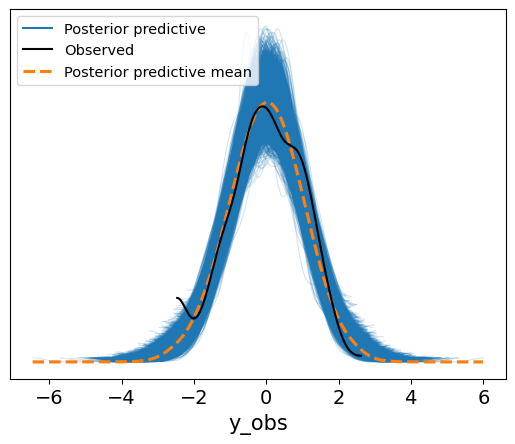

In [234]:
# Generate posterior predictive samples for checks
with model:
    posterior_predictive = pm.sample_posterior_predictive(idata, var_names=['y_obs'], return_inferencedata=True)

# Plot posterior predictive checks
az.plot_ppc(posterior_predictive, kind='kde', data_pairs={'y_obs': 'y_obs'})

# Show the plot
plt.show()

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

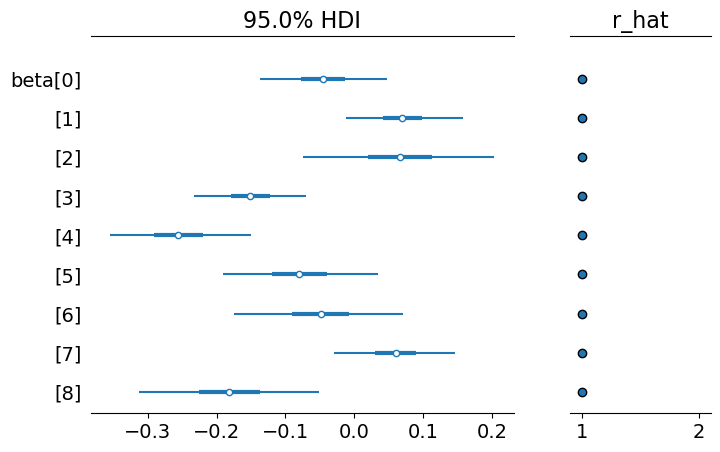

In [235]:
az.plot_forest(idata, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True)

#### Trace plots

Interpretation of Trace Plots

    Density Plots (Left Column):
        Each subplot on the left shows the kernel density estimate of the posterior distribution for a parameter.
        These plots give an idea of the central tendency (mean or median) and the spread (variance) of the parameter estimates.
        For example, the density plot for beta shows multiple colored curves corresponding to different chains, indicating the posterior distributions of the coefficients.

    Trace Plots (Right Column):
        Each subplot on the right shows the sampled values of the parameter across iterations for each chain.
        These plots help in assessing the convergence of the Markov Chain Monte Carlo (MCMC) sampling.
        A good trace plot should look like a "hairy caterpillar," with the chains mixing well and no apparent trends or patterns over iterations.

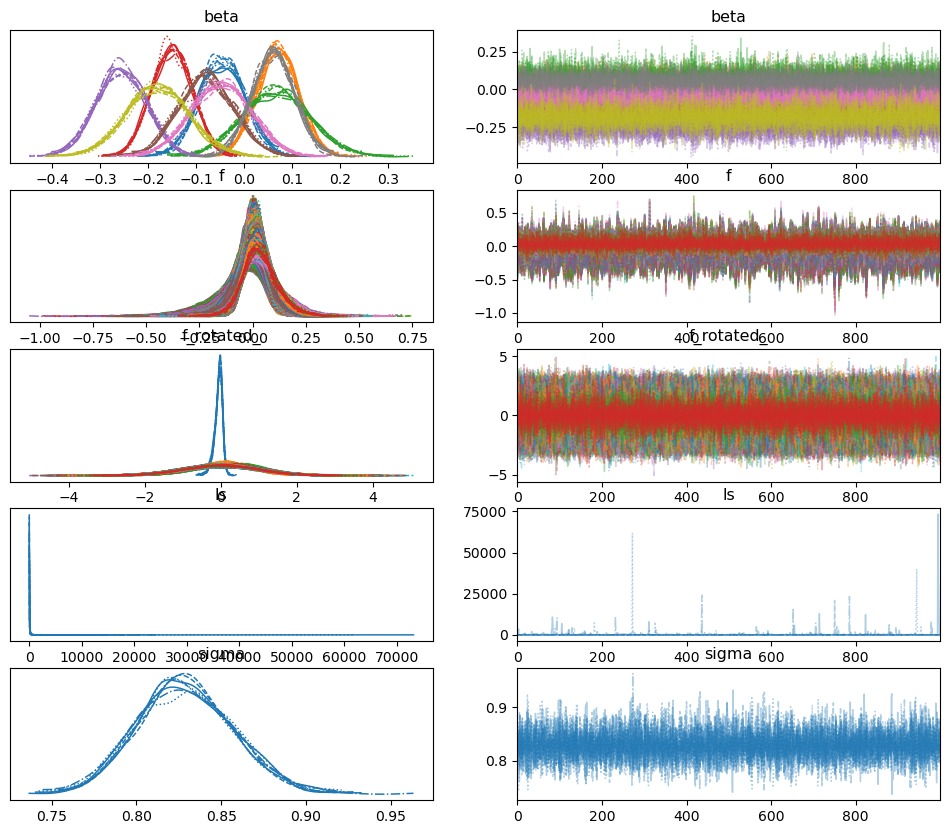

In [236]:
import matplotlib.pyplot as plt

# Generate the trace plot
trace_plot = az.plot_trace(idata)

# Save the plot to a file
plt.savefig('temp_files/report/9. trace_plot.pdf')

### Residual Analysis

#### Spatial Residual Plots 

Plot residuals (the differences between observed and predicted values) over the spatial domain to check for patterns. Randomly distributed residuals indicate a good fit.

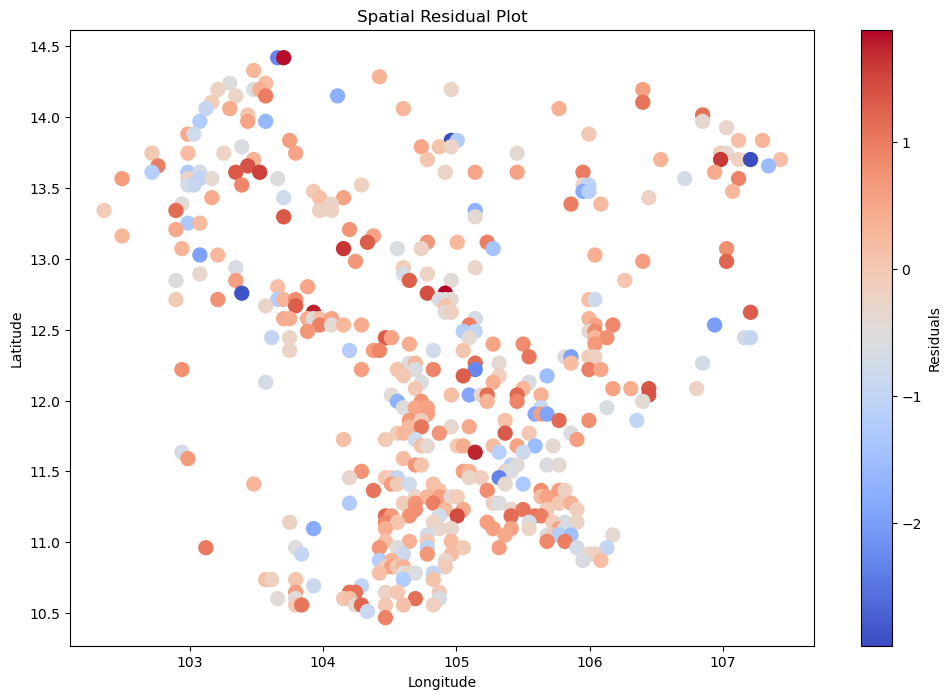

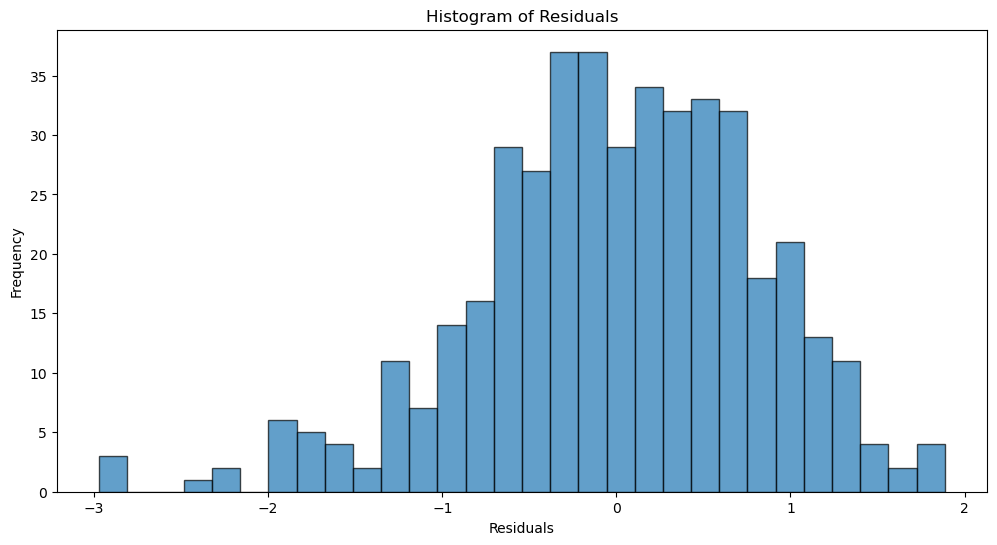

In [237]:
# Extract the observed data
y_obs = posterior_predictive.observed_data['y_obs'].values

# Calculate the mean of the simulated data across chains and draws
y_sim = posterior_predictive.posterior_predictive['y_obs'].mean(dim=('chain', 'draw')).values

# Calculate residuals
residuals = y_obs - y_sim

# Plot spatial residuals
plt.figure(figsize=(12, 8))
sc = plt.scatter(coordinates_observed[:, 0], coordinates_observed[:, 1], c=residuals, cmap='coolwarm', s=100)
plt.colorbar(sc, label='Residuals')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Residual Plot')
plt.show()

# Histogram of residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

### Uncertainty Quantification

	•	Credible Intervals: Evaluate the width of the credible intervals for predictions. Narrower intervals indicate higher precision, but they should still encompass the true values.
	•	Uncertainty Maps: Generate maps of prediction uncertainty to visualize areas of high and low certainty in the predictions.

#### Credible Intervals

Evaluate the width of the credible intervals for predictions. Narrower intervals indicate higher precision, but they should still encompass the true values.

Sampling: [y_obs]


Output()

Coverage of 95% Credible Intervals: 95.62%


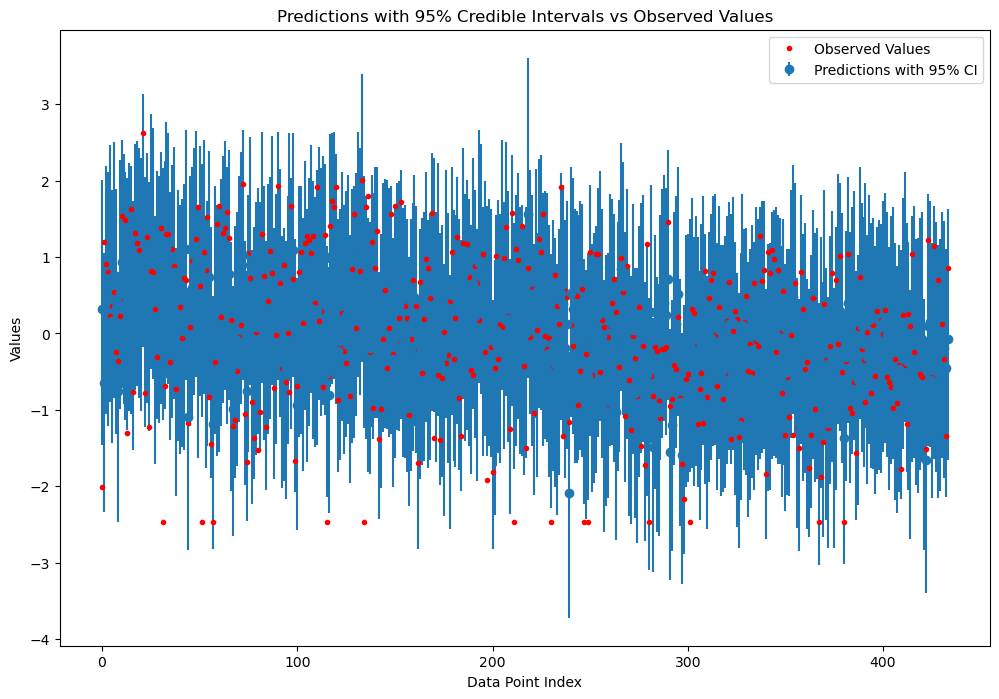

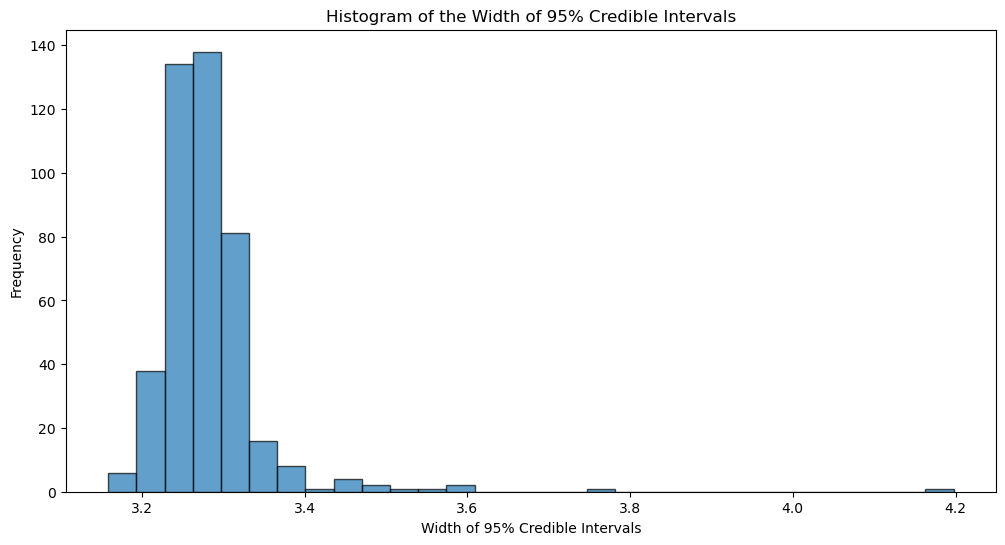

In [238]:
# Extract the observed and simulated data
y_obs = response

# Generate posterior predictive samples for checks
with model:
    posterior_predictive = pm.sample_posterior_predictive(idata, var_names=['y_obs'], return_inferencedata=True)

# Extract the mean prediction, lower and upper bounds of the 95% credible intervals
y_sim = posterior_predictive.posterior_predictive['y_obs'].mean(dim=("chain", "draw")).values
hdi = az.hdi(posterior_predictive.posterior_predictive, hdi_prob=0.95)['y_obs']

# Calculate the width of the credible intervals
ci_width = hdi[:, 1] - hdi[:, 0]

# Check how many true values are within the credible intervals
within_ci = np.sum((y_obs >= hdi[:, 0]) & (y_obs <= hdi[:, 1]))
total_obs = len(y_obs)
coverage = within_ci / total_obs

print(f"Coverage of 95% Credible Intervals: {coverage * 100:.2f}%")

# Plot the credible intervals vs the observed values
plt.figure(figsize=(12, 8))
plt.errorbar(np.arange(len(y_obs)), y_sim, yerr=[y_sim - hdi[:, 0], hdi[:, 1] - y_sim], fmt='o', label='Predictions with 95% CI')
plt.plot(np.arange(len(y_obs)), y_obs, 'r.', label='Observed Values')
plt.xlabel('Data Point Index')
plt.ylabel('Values')
plt.title('Predictions with 95% Credible Intervals vs Observed Values')
plt.legend()
plt.show()

# Plot the width of the credible intervals
plt.figure(figsize=(12, 6))
plt.hist(ci_width, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Width of 95% Credible Intervals')
plt.ylabel('Frequency')
plt.title('Histogram of the Width of 95% Credible Intervals')
plt.show()

### Transform the results back to original scale

In [239]:
report

{'Country': 'KHM',
 'DHS survey year': 2014,
 'Target Indicator': 'mpi',
 'Urban-rural threshold': 25,
 'Buffer Size (KM)': 10.0,
 'DHS clusters before urban masking': 611,
 'Grids before masking': 7793,
 'CRS': 'WGS 84',
 'Grids after masking': 7667,
 'DHS clusters after masking': 534,
 'Girds with multiple clusters': 433,
 'Covariates before filtering': 215,
 'Covariates after filtering by -+ 1y': 67,
 'Covariates after square and square-root transforms': 176,
 'Covariates after pairwise interactions': 15576,
 'Target mean pre transform': 0.19655064341937822,
 'Target std pre transform': 0.13349268877192644,
 'Transformation Applied': 'sqrt',
 'Lambda': None,
 'Number of covariates selected after Lasso': 9,
 'Target mean': 0.41085549914636554,
 'Target std': 0.16657851674381377}

#### Revert observed

In [240]:
y_denormalized = functions.revert_standardization(response, report['Target mean'], report['Target std'])

In [241]:
y_original_scale = functions.revert_transformation(y_denormalized, 
                                report['Transformation Applied'],
                                report['Target mean'], 
                                report['Target std'], 
                               report['Lambda']).round(4)

#### Revert predicted

In [242]:
y_sim_dn = functions.revert_standardization(y_sim, report['Target mean'], report['Target std'])

In [243]:
y_sim_original_scale = functions.revert_transformation(y_sim_dn, 
                                report['Transformation Applied'],
                                report['Target mean'], 
                                report['Target std'], 
                               report['Lambda']).round(4)

### Prediction Accuracy Metrics (at original scale)

#### Mean Absolute Error (MAE)

Measures the average magnitude of the errors in a set of predictions, without considering their direction.

In [244]:
# Calculate the absolute errors
absolute_errors = np.abs(y_original_scale - y_sim_original_scale)

# Calculate the Mean Absolute Error
mae = np.mean(absolute_errors)

print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.0854430875576037


In [245]:
report['Target mean pre transform']

0.19655064341937822

In [246]:
report['Bayesian model MAE'] = mae

#### Root Mean Squared Error (RMSE) 

Measures the square root of the average of squared differences between predicted and observed values, providing an indication of the model’s overall error.

In [247]:
# Calculate the squared errors
squared_errors = np.square(y_original_scale - y_sim_original_scale)

# Calculate the Mean Squared Error (MSE)
mse = np.mean(squared_errors)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 0.10960783939217668


In [248]:
report['Bayesian RMSE'] = rmse

In [249]:
#Save report as pickle
with open('temp_files/report/report.pkl', 'wb') as pickle_file:
    pickle.dump(report, pickle_file)

In [250]:
report

{'Country': 'KHM',
 'DHS survey year': 2014,
 'Target Indicator': 'mpi',
 'Urban-rural threshold': 25,
 'Buffer Size (KM)': 10.0,
 'DHS clusters before urban masking': 611,
 'Grids before masking': 7793,
 'CRS': 'WGS 84',
 'Grids after masking': 7667,
 'DHS clusters after masking': 534,
 'Girds with multiple clusters': 433,
 'Covariates before filtering': 215,
 'Covariates after filtering by -+ 1y': 67,
 'Covariates after square and square-root transforms': 176,
 'Covariates after pairwise interactions': 15576,
 'Target mean pre transform': 0.19655064341937822,
 'Target std pre transform': 0.13349268877192644,
 'Transformation Applied': 'sqrt',
 'Lambda': None,
 'Number of covariates selected after Lasso': 9,
 'Target mean': 0.41085549914636554,
 'Target std': 0.16657851674381377,
 'Bayesian model MAE': 0.0854430875576037,
 'Bayesian RMSE': 0.10960783939217668}